In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
%matplotlib inline
import time

In [3]:
DATA = pd.read_csv("/data/zkp/buy2/service/DATA.csv")
DATA_X = np.load("/data/zkp/buy2/service/DATA.npy")

# DATA_X = DATA_X[(DATA.container_ip=="33.61.250.148")]
# DATA = DATA[(DATA.container_ip=="33.61.250.148")]

X = []

In [7]:
DATA

,sample_time,container_ip,cpu_util__pct,mem_util__pct,qps__Q_s,rt__ms_Q
0,1644336000,11.16.93.191,7.529167,81.355071,1.883333,185.672566
1,1644336060,11.16.93.191,8.158333,81.437802,1.333333,186.262500
2,1644336120,11.16.93.191,7.287500,81.400371,1.300000,209.615385
3,1644336180,11.16.93.191,7.458333,81.396174,1.200000,212.847222
4,1644336240,11.16.93.191,6.847917,81.355047,1.383333,172.108434
...,...,...,...,...,...,...
1901059,1644508440,33.62.113.198,7.310417,77.880001,1.383333,181.843373
1901060,1644508500,33.62.113.198,7.352083,77.882814,1.433333,190.511628
1901061,1644508560,33.62.113.198,7.502083,77.846694,1.500000,197.488889
1901062,1644508620,33.62.113.198,7.408333,77.930188,1.333333,206.550000


In [527]:
mp = {}
cpu = offline.cpu_util__pct.values
t = offline.sample_time.values
for i in range(offline.shape[0]):
    mp[t[i]] = [cpu[i]]

In [528]:
for ip in svc.container_ip.unique():
    temp = svc[svc.container_ip==ip]
    t = temp.sample_time__m.apply(lambda x:int(time.mktime(time.strptime(x, "%Y-%m-%d %H:%M:%S")))).values
    r = temp["rank"].values
    for i in range(t.shape[0]):
        if t[i] in mp:
            mp[t[i]].append(r[i])


In [529]:
mpp = []
for key in mp:
    if len(mp[key]) == 6:
        mpp.append(mp[key])
#         X.append(DATA_X[DATA.sample_time==key])
mpp = np.asarray(mpp)

In [531]:
# X = np.asarray(X).reshape(-1, 60)
X.shape, mpp.shape

((749, 60), (749, 6))

In [497]:
for i in range(1, 6):
    mpp[:, i] = (mpp[:, i] - np.mean(mpp[:, i])) / np.std(mpp[:, i])

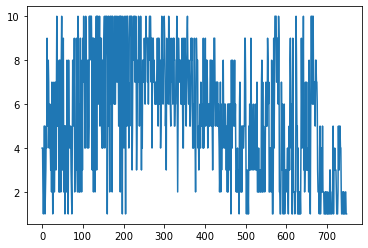

In [532]:
plt.plot(range(mpp[:, 1].shape[0]), mpp[:, 1])

In [533]:
mean = []
for ip in svc.container_ip.unique():
    temp = svc[svc.container_ip==ip]
    mean.append(np.mean(temp.rt__ms_Q.values))


In [552]:
svc.container_ip.unique()

array(['33.61.140.251', '33.61.146.72', '33.61.232.125', '33.61.250.148',
       '33.62.104.93'], dtype=object)

In [534]:
np.corrcoef(mpp.T)

array([[ 1.        ,  0.5153315 , -0.30164886,  0.25607057,  0.32289772,
        -0.00710177],
       [ 0.5153315 ,  1.        , -0.26302765,  0.16189546,  0.32393515,
        -0.03012387],
       [-0.30164886, -0.26302765,  1.        , -0.05188344, -0.33931282,
        -0.01134678],
       [ 0.25607057,  0.16189546, -0.05188344,  1.        ,  0.07597017,
        -0.02170895],
       [ 0.32289772,  0.32393515, -0.33931282,  0.07597017,  1.        ,
        -0.01028705],
       [-0.00710177, -0.03012387, -0.01134678, -0.02170895, -0.01028705,
         1.        ]])

In [729]:
y = []
for i in range(mpp.shape[0]):
    y.append(mpp[i, 1]*0.515*16 + mpp[i, 3]*0.256*4 + mpp[i, 4]*0.323*8)

In [730]:
y = np.asarray(y)

In [731]:
y = (y - min(y)) / (max(y) - min(y))

In [732]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.5144876201871771

In [727]:
predict = model.predict(X)
plt.scatter(predict, y)
plt.xlabel("Predict score")
plt.ylabel("Machine level interference")

In [8]:
pod_meta  = pd.read_csv("/data/zkp/pod_meta.csv")
pod_meta

,Unnamed: 0,container_sn,container_ip,container_hostname,nc_sn,nc_ip,nc_hostname,container_app_name,container_app_group_name,cell,...,gpu_limit,is_del,pod_status,pod_reason,is_mix_deploy,is_on_ecs,creation_time,scheduled_time,deletion_time,ds
0,156855,amdc--99b47c5b-607b-4a7a-8717-7242db31ad53,33.3.248.197,amdc033003248197.center.na610,i-8vbc06xfwoxcgm6g9a5d,11.16.92.123,phyhost-ecs-ali011016092123.na610,amdc,amdchost,na610,...,0.0,N,Running,NaN,Y,Y,2020-07-21 16:12:55,2020-07-21 16:13:13,2122-01-12 11:32:46,20220206
1,158982,846e9730-326c-40e0-bdbf-f018cfbe6fad,33.3.228.246,amp-imba-dispatcher033003228246.center.na610,i-8vbc06xfwoxcgm6g9a5d,11.16.92.123,phyhost-ecs-ali011016092123.na610,amp-imba-dispatcher,amp-imba-dispatcherhost,na610,...,0.0,N,Running,NaN,Y,Y,2020-08-25 14:42:26,2020-08-25 14:42:28,2122-01-18 19:25:02,20220206
2,158449,ccd04ca2-62e5-4d4a-a626-f9c2d4909dbc,33.4.31.85,jingwei3-worker033004031085.center.na610,i-8vbc06xfwoxcgm6g9a5d,11.16.92.123,phyhost-ecs-ali011016092123.na610,jingwei3-worker,jingwei3-online-cloud1host,na610,...,0.0,N,Running,NaN,Y,Y,2021-06-25 13:52:40,2021-06-25 13:53:44,2121-12-14 13:24:08,20220206
3,158436,94ee5beb-f2b5-4db7-af07-876028709b76,33.3.223.74,inventoryscheduler033003223074.center.na610,i-8vbc06xfwoxcgm6g9a5d,11.16.92.123,phyhost-ecs-ali011016092123.na610,inventoryscheduler,inventoryschedulerhost,na610,...,0.0,N,Running,NaN,Y,Y,2021-04-19 14:01:51,2021-04-19 14:01:58,2122-01-27 15:59:50,20220206
4,157758,bbq--6bf8798f-3c21-43ef-aeee-6661b8fc4e0b,33.4.8.17,bbq033004008017.center.na610,i-8vbc06xfwoxcgm6g9a5d,11.16.92.123,phyhost-ecs-ali011016092123.na610,bbq,bbqhost,na610,...,0.0,N,Running,NaN,Y,Y,2021-09-11 15:00:42,2021-09-11 15:04:54,2122-01-07 16:46:42,20220206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192359,81295,starliner--26fc20f4-597a-4355-b355-f1098d9507fe,33.54.35.234,starliner033054035234.center.na610,i-8vb7u9c6qu94nxytwv5l,33.9.99.94,phyhost-ecs-ali033009099094.na610,starliner,starlinerhost,na610,...,0.0,N,Running,NaN,N,Y,2021-07-26 15:02:37,2021-07-26 15:02:52,2122-01-27 13:53:50,20220206
192360,82553,e0dae341-e06a-4f5e-b11f-f6b3615cbd2c,33.54.34.120,wukong-alphago033054034120.center.na610,i-8vb7u9c6qu94nxytwv5l,33.9.99.94,phyhost-ecs-ali033009099094.na610,wukong-alphago,wukong-alphagohost_mobile002,na610,...,0.0,N,Running,NaN,N,Y,2021-07-26 00:18:41,2021-07-26 00:18:50,2122-01-25 11:38:20,20220206
192361,81124,upp--42b0c774-1d37-4899-86c2-453a0d985f6f,33.54.36.45,upp033054036045.center.na610,i-8vb7u9c6qu94nxytwv5l,33.9.99.94,phyhost-ecs-ali033009099094.na610,upp,upp_cartshost,na610,...,0.0,N,Running,NaN,N,Y,2021-09-11 14:36:32,2021-09-11 14:44:23,2122-01-20 14:47:02,20220206
192362,82736,d55cd382-f197-46c2-a1c8-a48b62a1dea7,33.54.33.145,wukong-im-processor033054033145.center.na610,i-8vb7u9c6qu94nxytwv5l,33.9.99.94,phyhost-ecs-ali033009099094.na610,wukong-im-processor,wukong-im-processor-highhost,na610,...,0.0,N,Running,NaN,N,Y,2021-07-25 23:56:50,2021-07-25 23:56:58,2122-01-17 14:23:08,20220206


In [583]:
svc = pd.read_csv("/data/zkp/buy2/service/allservice2.csv")
svc = svc[(svc.throughput_type=="HSF") &(~pd.isna(svc.rt__ms_Q))]

In [594]:
onoffline = pd.read_csv("/data/zkp/buy2/service/onoffline2.csv")
offline = onoffline[onoffline.Task_Type=="Offline"]

In [3]:
# DATA = pd.merge(DATA, pod_meta[["container_ip", "container_app_group_name"]], on=["container_ip"], how="left")
DATA = pd.read_csv("/data/zkp/buy2/service/allservice3.csv")

In [26]:
DATA = DATA.sort_values(by=["container_app_group_name"])

In [206]:
data = DATA[DATA.sample_time<1644422400]
data = data[["container_app_group_name", "rt__ms_Q", "CPU_time__s"]]
data = data.sort_values(by=["container_app_group_name"])
data

,container_app_group_name,rt__ms_Q,CPU_time__s
0,aboxhost,23.857143,1388.183563
7605,aboxhost,22.732323,NaN
7604,aboxhost,29.060606,NaN
7603,aboxhost,24.123457,NaN
7600,aboxhost,23.103321,1832.863103
...,...,...,...
24426076,zuanshi_servicehost,16.160377,1237.385476
24426077,zuanshi_servicehost,21.068182,1146.365359
24426078,zuanshi_servicehost,2.564723,NaN
24426057,zuanshi_servicehost,8.288206,1330.118964


In [11]:
corr1 = {}
for app in data.container_app_group_name.unique():
    temp = data[(data.container_app_group_name==app) & (~pd.isna(data.CPU_time__s))]
    if temp.shape[0] < 100:
        corr1[app] = 0
        continue
    c1 = temp.rt__ms_Q.corr(temp.CPU_time__s)
    if np.isnan(c1):
        c1 = 0
    corr1[app] = c1

In [1054]:
corr1["ump2_detailhost"], corr2["ump2_detailhost"]

(0.2845044379463524, 0.005694335132810743)

In [207]:
rtP1 = {}
for app in data.container_app_group_name.unique():
    temp = data[data.container_app_group_name==app]
    if temp.shape[0] < 100:
        rtP1[app] = 0
        continue
#     rtP1[app] = np.std(temp.rt__ms_Q.values) / np.mean(temp.rt__ms_Q.values) if np.mean(temp.rt__ms_Q.values) else 0
    rtP1[app] = np.percentile(temp.rt__ms_Q.values, 95) / np.percentile(temp.rt__ms_Q.values, 50) if np.percentile(temp.rt__ms_Q.values, 50) else 0

In [30]:
score = []
for app in DATA.container_app_group_name.unique():
    temp = data[data.container_app_group_name==app].rt__ms_Q.values
    if temp.shape[0] < 10:
        for i in range(DATA[DATA.container_app_group_name==app].shape[0]):
            score.append(0)
        continue
    p = []
    for i in range(10, 101, 10):
        p.append(np.percentile(temp, i))
    rt = DATA[DATA.container_app_group_name==app].rt__ms_Q.values
    for i in rt:
        for j in range(1, 11):
            if i <= p[j-1] or j == 10:
                score.append(j)
                break
DATA["score"] = score    

In [208]:
# co = []
# rtP = []
rtPP = []
for app in DATA.container_app_group_name.values:
    if app in rtP1:
#         co.append(corr1[app])
#         rtP.append(rtP1[app])
        rtPP.append(rtP1[app])
    else:
#         co.append(0)
#         rtP.append(0)
        rtPP.append(0)
# DATA["co"] = co
DATA["rtPP"] = rtPP

In [2200]:
buy2 = pd.read_csv("/data/zkp/buy2/service/DATA.csv")
buy2_X = np.load("/data/zkp/buy2/service/DATA.npy")

In [2201]:
temp = []
for x in buy2_X:
    temp.append(x)
buy2["X"] = temp

In [2202]:
buy2 = pd.merge(buy2, pod_meta[["nc_sn", "container_ip"]], on=["container_ip"], how="left")
DATA = buy2
# DATA = pd.merge(DATA, buy2[["nc_sn", "sample_time", "X"]], on=["nc_sn", "sample_time"], how="left")

In [2203]:
DATA

,sample_time,container_ip,cpu_util__pct,mem_util__pct,qps__Q_s,rt__ms_Q,X,nc_sn
0,1644336000,11.16.93.191,7.529167,81.355071,1.883333,185.672566,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",i-8vbgza7a5ikbdkgvukub
1,1644336060,11.16.93.191,8.158333,81.437802,1.333333,186.262500,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",i-8vbgza7a5ikbdkgvukub
2,1644336120,11.16.93.191,7.287500,81.400371,1.300000,209.615385,"[0, 0, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",i-8vbgza7a5ikbdkgvukub
3,1644336180,11.16.93.191,7.458333,81.396174,1.200000,212.847222,"[0, 0, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 1, 0, 1, ...",i-8vbgza7a5ikbdkgvukub
4,1644336240,11.16.93.191,6.847917,81.355047,1.383333,172.108434,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",i-8vbgza7a5ikbdkgvukub
...,...,...,...,...,...,...,...,...
1901059,1644508440,33.62.113.198,7.310417,77.880001,1.383333,181.843373,"[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, ...",i-8vbep5emxamlhkdcr3ap
1901060,1644508500,33.62.113.198,7.352083,77.882814,1.433333,190.511628,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",i-8vbep5emxamlhkdcr3ap
1901061,1644508560,33.62.113.198,7.502083,77.846694,1.500000,197.488889,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",i-8vbep5emxamlhkdcr3ap
1901062,1644508620,33.62.113.198,7.408333,77.930188,1.333333,206.550000,"[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",i-8vbep5emxamlhkdcr3ap


In [969]:
X = [[], [], [], []]
y = [[], [], [], []]
for nc in data.nc_sn.unique():
    y_nc = []
    X_nc = []
    temp = data[data.nc_sn==nc]
    for t in temp.sample_time.unique():
        tep = temp[temp.sample_time==t]
        y_nc.append([np.sum(tep["score"].values),
                     np.sum(tep["score"].values*tep.request_cpu.values),
                     np.sum(tep["score"].values*tep.rt__ms_Q.values),
                     np.sum(tep["rank"].values*tep["corr"].values),
                    ])
        X_nc.append(tep.X.values[0])
    y_nc = np.asarray(y_nc)
    X_nc = np.asarray(X_nc)
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_nc, y_nc[:, [i]])
        scaler = MinMaxScaler().fit(y_train)
        y_test = scaler.transform(y_test)
        for j in y_test:
            y[i].append(j[0])
        for j in X_test:
            X[i].append(j)

KeyboardInterrupt: 

In [ ]:
X = np.asarray(X).T
y = np.asarray(y).T

In [ ]:
X.shape, y.shape

-0.020603404127748526


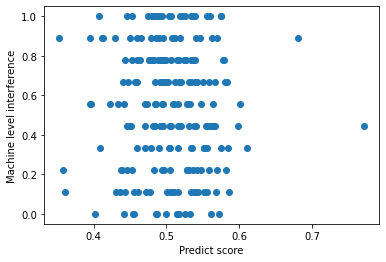

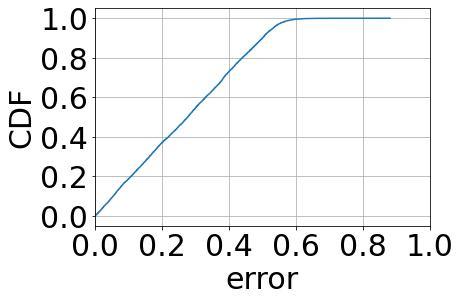

-0.0150617325593283


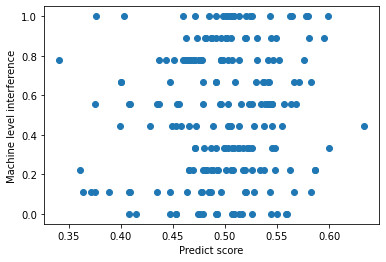

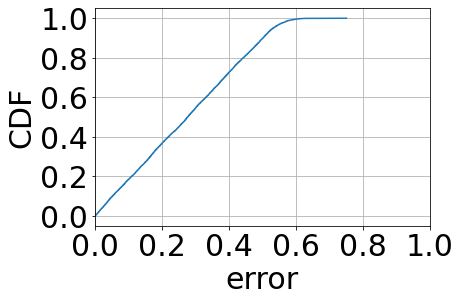

-0.03482762209258716


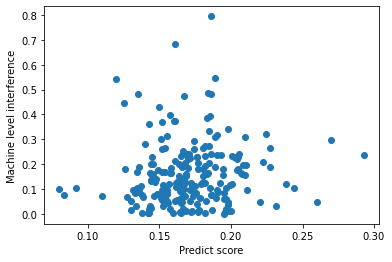

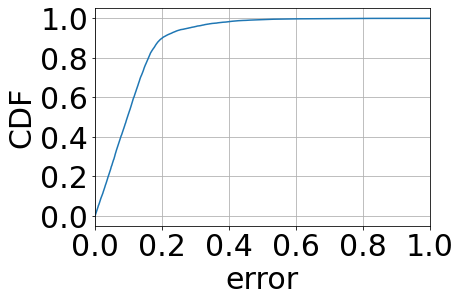

-0.02279011478769344


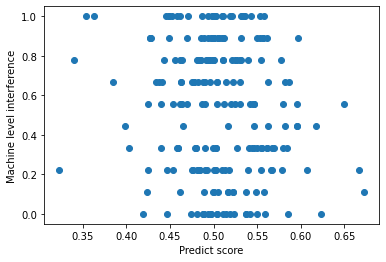

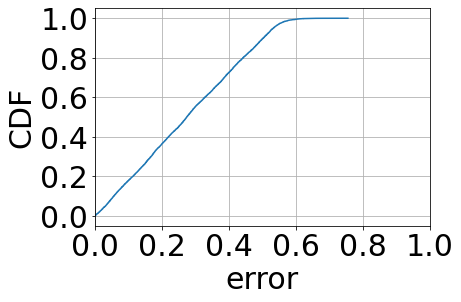

0.21805845030540227


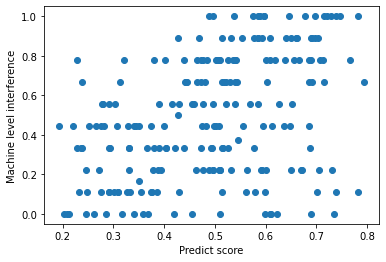

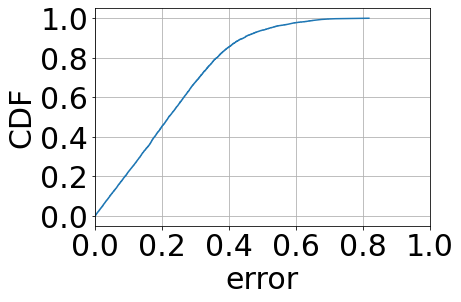

In [964]:
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y[:, i])
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))
    
    predict = model.predict(X_test)
    plt.scatter(predict[::50], y_test[::50])
    plt.xlabel("Predict score")
    plt.ylabel("Machine level interference")
    plt.show()

    error = abs(predict - y_test)
    plt.plot(sorted(error), np.arange(predict.shape[0]) / (predict.shape[0] - 1))
    plt.xlim(0, 1)
    plt.xlabel("error", fontsize=30)
    plt.ylabel("CDF", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(":")
    plt.show()

In [210]:
P = [[], [], [], []]
T = [[], [], [], []]
for nc in data.nc_sn.unique():
#     if nc != "i-8vb8e59yufyqspqng372":
#         continue
    X = []
    y = []
    temp = data[data.nc_sn==nc]
    for t in temp.sample_time.unique():
        tep = temp[temp.sample_time==t]
        y.append([np.sum(tep["score"].values),
                  np.sum(tep["score"].values*tep.request_cpu.values),
                  np.sum(tep["score"].values*tep["co"].values),
                  np.sum(tep["score"].values*tep["rtPP"].values),
                  ])
        X.append(tep.X.values[0])
    X = np.asarray(X)
    if X.shape[0] < 1000:
        continue
    y = np.asarray(y)
    for index in range(4):
        p = []
        for i in range(10, 101, 10):
            p.append(np.percentile(y[:, index], i))
        y_new = []
        for i in y[:, index]:
            for j in range(1, 11):
                if i <= p[j-1]:
                    y_new.append(j)
                    break
        y[:, index] = np.asarray(y_new)
#         y[:, index] = (y[:, index] - np.percentile(y[:, index], 1)) / (np.percentile(y[:, index], 99) - np.percentile(y[:, index], 1))

    print(nc, end=' ')
    for index in range(4):
        model = RandomForestClassifier()
        X_train, X_test, y_train, y_test = train_test_split(X, y[:, index])
#         scaler = MinMaxScaler().fit(y_train)
#         y_train = scaler.transform(y_train)
#         y_test = scaler.transform(y_test)
        model.fit(X_train, y_train)
        print(model.score(X_test, y_test), end='\t')
        predict = model.predict(X_test)
    #     plt.scatter(predict, y)
    #     plt.xlabel("Predict score")
    #     plt.ylabel("Machine level interference")
    #     plt.show()
#         e = abs(predict - y_test)
#         for i in e:
        P[index].append(predict)
        T[index].append(y_test)
    print()
#     plt.scatter(predict, scaler.transform(y[:, [index]]))
#     plt.xlabel("predict")
#     plt.ylabel("interference score")

i-8vb8e59yufyqu32f9sqf 0.19220055710306408	0.1615598885793872	0.22841225626740946	0.1615598885793872	
i-8vb4832m1txx681l0177 0.18994413407821228	0.18435754189944134	0.32122905027932963	0.23184357541899442	
i-8vb966yuj0745jsp3bno 0.22346368715083798	0.18156424581005587	0.22346368715083798	0.2122905027932961	
i-8vbbk8hkmovcnnqvevi7 0.24581005586592178	0.20949720670391062	0.19553072625698323	0.2905027932960894	
i-8vbgt2f6yyj048bs31ef 0.19273743016759776	0.24860335195530725	0.26256983240223464	0.1787709497206704	
i-8vb2t1xpt6kzeo7111of 0.18435754189944134	0.17597765363128492	0.24581005586592178	0.17039106145251395	
i-8vbj9l58uteg06ghntqo 0.22625698324022347	0.26256983240223464	0.27932960893854747	0.15363128491620112	
i-8vbbnyakjj0ya1rsr0uq 0.20055710306406685	0.1894150417827298	0.25348189415041783	0.1894150417827298	
i-8vbekxwwqxx1rqiotsy6 0.22625698324022347	0.20391061452513967	0.26536312849162014	0.19553072625698323	
i-8vb2tmp6gstoynuyzsy6 0.18435754189944134	0.2011173184357542	0.2458100

In [227]:
MODEL = {}
P = {}

In [229]:
for nc in data.nc_sn.unique():
    X = []
    y = []
    temp = data[data.nc_sn==nc]
    sample_time = temp.sample_time.unique()
    for t in sample_time:
        tep = temp[temp.sample_time==t]
        y.append(np.sum(tep["score"].values*tep["co"].values))
        X.append(tep.X.values[0])
    X = np.asarray(X)
    if X.shape[0] < 1000:
        continue
    y = np.asarray(y)
    p = []
    for i in range(10, 101, 10):
        p.append(np.percentile(y, i))
    for i in range(y.shape[0]):
        for j in range(1, 11):
            if y[i] <= p[j-1]:
                y[i] = j
                break

    print(nc, end=' ')
    model = RandomForestClassifier()
    X_train, X_test, y_train, y_test = X[sample_time<1644505200], X[sample_time>=1644505200],  y[sample_time<1644505200], y[sample_time>=1644505200]
    model.fit(X_train, y_train)
    MODEL[nc] = model
    P[nc] = model.predict(X_test)
    print(model.score(X_test, y_test), end='\t')

i-8vb8e59yufyqu32f9sqf 0.13559322033898305	i-8vb4832m1txx681l0177 0.2711864406779661	i-8vb966yuj0745jsp3bno 0.05084745762711865	i-8vbbk8hkmovcnnqvevi7 0.3728813559322034	i-8vbgt2f6yyj048bs31ef 0.4067796610169492	i-8vb2t1xpt6kzeo7111of 0.3728813559322034	i-8vbj9l58uteg06ghntqo 0.559322033898305	i-8vbbnyakjj0ya1rsr0uq 0.4745762711864407	i-8vbekxwwqxx1rqiotsy6 0.11864406779661017	i-8vb2tmp6gstoynuyzsy6 0.22033898305084745	i-8vb9qrifimlz7tgt2tg8 0.2033898305084746	i-8vbgv8uybhcizlxzw91a 0.3728813559322034	i-8vb7lwnuymw22lwl049r 0.3389830508474576	i-8vb94rg3lfm5dbbasaot 0.13559322033898305	i-8vb6fzvzjg9gi45wfhko 0.15254237288135594	i-8vb4znug003nginj1s9j 0.11864406779661017	i-8vbe1afq6fs0fsh1nl05 0.15254237288135594	i-8vb2t1xpt6kzgz2brw9c 0.2033898305084746	i-8vb7qlu8oz6wv1smogr2 0.1694915254237288	i-8vbfp9s69ya5xk2gnq5g 0.4745762711864407	i-8vbfp9s69ya6s51piwky 0.3559322033898305	i-8vbctex08c10vlo7db6k 0.1694915254237288	i-8vbd3whsqpuije3cc6os 0.3050847457627119	i-8vb94rg3lfm5ddabwcny 0.06

1644465600: 0.1596676737160121
+3600: 0.14778449144008057
+3600: 0.2510255560934594
+3600: 0.13641473759517606
+3600: 0.051544288301155344
-3600: 0.34655085599194363
-3600: 0.2919436052366566
-3600: 0.283031218529708
-3600: 0.39798590130916417
-3600: 0.4077794561933535
-3600: 0.7136203423967774
-3600: 0.7107754279959718
-3600: 0.7244712990936556
-3600: 0.7406847935548841

In [ ]:
1644498000, 1644422400, 1644440400

In [2182]:
TIMESTAMP = 1644422400

In [2181]:
for i in range(0, 3600*24, 3600):
    TIMESTAMP = 1644422400 + i
    print(TIMESTAMP, end=', ')
    base = DATA[(DATA.sample_time>TIMESTAMP) & (DATA.sample_time<TIMESTAMP + 3600)]
    print(base.machine_cpu.mean(), base.machine_cpu.std(), end=', ')
    # temp = data
    result = []
    for i in e_score:
        if i in MODEL:
            X = []
            for x in base[base.nc_sn==i].X.values:
                 X.append(x)

            for j in MODEL[i].predict(np.asarray(X)).tolist():
                result.append(j)

    base = np.bincount(result, minlength=11)
    SUM = 0
    for i in range(base.shape[0]):
        SUM += base[i] * i
    print(SUM / np.sum(base))

1644422400, 51.12379358083776 15.685522439547917, 5.410822262435451
1644426000, 56.441305761789884 8.8313600285013, 6.705022951977401
1644429600, 59.460659251698765 8.666289715508587, 7.6784516242937855
1644433200, 63.18569024769781 9.028303459986544, 8.209216101694915
1644436800, 60.58260488326942 8.75512872233038, 8.143405720338983
1644440400, 60.043187164134004 8.863098393880398, 8.105270127118644
1644444000, 61.6380796170144 8.552252403953172, 8.120542019774012
1644447600, 59.1009753247659 8.833365013735543, 6.5764918785310735
1644451200, 62.528915042856056 8.300085407942394, 6.762711864406779
1644454800, 60.24413968375676 9.502906957798402, 6.142743644067797
1644458400, 62.57729675927531 7.532310480800571, 6.3392478813559325
1644462000, 64.15750219419353 7.766537601125951, 6.640757415254237
1644465600, 56.57770772054887 15.177220725391171, 4.973340395480226
1644469200, 55.12552463783659 15.168224603216006, 4.817973163841808
1644472800, 55.780936604588994 14.592714208945594, 5.8131

In [1880]:
base = np.asarray(result).reshape(-1, 59)

In [1739]:
np.savetxt("/data/zkp/figure/simulation/base2_score.txt", result)

In [1738]:
result.shape

(344, 59)

In [1449]:
batch = pd.read_csv("/data/zkp/buy2/instance.csv")

In [1923]:
batch

,fuxi_job_name,fuxi_task_name,start_time,end_time,worker_address,fuxi_avg_cpu,fuxi_max_cpu,fuxi_avg_mem,fuxi_max_mem,job_task_name,total_time,type
0,aliexpress_ru_20220208160001498goefh3ys_SQL_0_...,M1,1644336002,1644336003,11.17.192.123,143.0,143.0,1902.0,NaN,aliexpress_ru_20220208160001498goefh3ys_SQL_0_...,1,32
1,cnscf_dev_20220208160004424gokrixte2_SQL_0_0_0...,M1,1644336005,1644336007,11.17.192.123,268.0,447.0,13688.0,NaN,cnscf_dev_20220208160004424gokrixte2_SQL_0_0_0...,2,56
2,dmw_ads_dev_20220208160004140gfkt1s06_SQL_0_0_...,M3,1644336006,1644336009,11.17.192.123,261.0,447.0,13796.0,NaN,dmw_ads_dev_20220208160004140gfkt1s06_SQL_0_0_...,3,56
3,dmw_ads_dev_20220208160004140gfkt1s06_SQL_0_0_...,M3,1644336006,1644336009,11.17.192.123,261.0,447.0,13775.0,NaN,dmw_ads_dev_20220208160004140gfkt1s06_SQL_0_0_...,3,56
4,dmw_ads_dev_20220208160004264gbkfef633_SQL_0_0...,M1,1644336006,1644336009,11.17.192.123,264.0,447.0,13741.0,NaN,dmw_ads_dev_20220208160004264gbkfef633_SQL_0_0...,3,56
...,...,...,...,...,...,...,...,...,...,...,...,...
80642804,cndata_20220210155843666gcdpi9a_SQL_0_0_0_job_0,M1,1644508725,1644508727,33.39.9.95,112.0,112.0,6897.0,NaN,cndata_20220210155843666gcdpi9a_SQL_0_0_0_job_0M1,2,32
80642805,cndata_20220210155851721g8bh4_SQL_0_0_0_job_0,M1,1644508733,1644508734,33.39.9.95,104.0,104.0,6865.0,NaN,cndata_20220210155851721g8bh4_SQL_0_0_0_job_0M1,1,32
80642806,cndata_20220210155854746gb7t88ys_SQL_0_0_0_job_0,M1,1644508735,1644508739,33.39.9.95,87.0,110.0,6907.0,NaN,cndata_20220210155854746gb7t88ys_SQL_0_0_0_job...,4,32
80642807,b2b_anti_20220210155900766gnxbh_SQL_0_0_0_job_0,M1,1644508741,1644508744,33.39.9.95,69.0,111.0,6868.0,NaN,b2b_anti_20220210155900766gnxbh_SQL_0_0_0_job_0M1,3,32


In [1451]:
batch["job_task_name"] = batch.fuxi_job_name + batch.fuxi_task_name
batch["total_time"] = batch.end_time - batch.start_time
G = batch[["job_task_name", "fuxi_avg_cpu", "fuxi_avg_mem", "total_time"]].groupby(["job_task_name"]).mean()

In [1452]:
task_type = {}
type_cnt = [0 for i in range(60)]
cpu = G.fuxi_avg_cpu.values
mem = G.fuxi_avg_mem.values
t = G.total_time.values
key = G.index.values
for i in range(G.shape[0]):
    if np.isnan(cpu[i]) or np.isnan(mem[i]) or np.isnan(t[i]):
        continue
    index = 0
    if cpu[i] < 50:
        index = 0
    elif 50 <= cpu[i] < 150:
        index = 1
    else:
        index = 2

    if mem[i] < 512:
        index = (index*5) + 0
    elif 512 <= mem[i] < 1536:
        index = (index*5) + 1
    elif 1536 <= mem[i] < 3072:
        index = (index*5) + 2
    elif 3072 <= mem[i] < 6144:
        index = (index*5) + 3
    else:
        index = (index*5) + 4

    if t[i] < 20:
        index = (index*4) + 0
    elif 20 <= t[i] < 40:
        index = (index*4) + 1
    elif 40 <= t[i] < 100:
        index = (index*4) + 2
    else:
        index = (index*4) + 3
    task_type[key[i]] = index
    type_cnt[index] += 1

In [1453]:
temp = []
for i in batch.job_task_name.values:
    if i in task_type:
        temp.append(int(task_type[i]))
    else:
        temp.append(np.nan)
batch["type"] = temp

In [1455]:
batch = batch[~np.isnan(batch.type)]
batch = batch[~((batch.start_time==0) | (batch.end_time==0))]
batch = batch[~pd.isna(batch.worker_address)]
batch.type = np.asarray(batch.type, dtype="int")

In [2204]:
queue = batch[(batch.start_time>=TIMESTAMP) & (batch.start_time<TIMESTAMP+3600)]

In [2205]:
queue

,fuxi_job_name,fuxi_task_name,start_time,end_time,worker_address,fuxi_avg_cpu,fuxi_max_cpu,fuxi_avg_mem,fuxi_max_mem,job_task_name,total_time,type
72621,aeoperation_dev_20220209160002553g7sht641_SQL_...,M1,1644422404,1644422414,11.17.192.123,354.0,443.0,18802.0,NaN,aeoperation_dev_20220209160002553g7sht641_SQL_...,10,56
72622,cnglb_dev_20220209160003534glhaaol_SQL_0_0_0_j...,M4,1644422404,1644422416,11.17.192.123,337.0,443.0,18908.0,NaN,cnglb_dev_20220209160003534glhaaol_SQL_0_0_0_j...,12,56
72623,aeoperation_dev_20220209160003972ggezy9s_SQL_0...,M2_1,1644422405,1644422415,11.17.192.123,343.0,443.0,18888.0,NaN,aeoperation_dev_20220209160003972ggezy9s_SQL_0...,10,56
72624,aliexpress_ru_dev_2022020916000399gah8ud76_SQL...,M2_1,1644422406,1644422409,11.17.192.123,307.0,381.0,18689.0,NaN,aliexpress_ru_dev_2022020916000399gah8ud76_SQL...,3,56
72625,cntp_dev_20220209160006711gh510741_SQL_0_0_0_j...,M1,1644422407,1644422407,11.17.192.123,71.0,71.0,607.0,NaN,cntp_dev_20220209160006711gh510741_SQL_0_0_0_j...,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...
80592641,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,M4,1644425998,1644426609,33.39.9.95,5.0,78.0,579.0,624.0,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,611,7
80592642,cnftms_20220209165747795gns7i2_SQL_0_1_1_job_1,M10_17_22,1644425998,1644426008,33.39.9.95,36.0,69.0,303.0,314.0,cnftms_20220209165747795gns7i2_SQL_0_1_1_job_1...,10,0
80592643,cnftms_20220209165747795gns7i2_SQL_0_1_1_job_1,M10_17_22,1644425998,1644426016,33.39.9.95,20.0,58.0,294.0,302.0,cnftms_20220209165747795gns7i2_SQL_0_1_1_job_1...,18,0
80592644,cnftms_20220209165747795gns7i2_SQL_0_1_1_job_1,M10_17_22,1644425998,1644426008,33.39.9.95,38.0,59.0,312.0,323.0,cnftms_20220209165747795gns7i2_SQL_0_1_1_job_1...,10,0


In [2206]:
data = DATA[["nc_sn", "sample_time", "X"]]
data = data.dropna()
data = data[(data.sample_time>=TIMESTAMP) & (data.sample_time<TIMESTAMP+3600)]

In [2207]:
data

/home/admin/anaconda3/lib/python3.8/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,nc_sn,sample_time,X
1439,i-8vbgza7a5ikbdkgvukub,1644422400,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1440,i-8vbgza7a5ikbdkgvukub,1644422460,"[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1441,i-8vbgza7a5ikbdkgvukub,1644422520,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1442,i-8vbgza7a5ikbdkgvukub,1644422580,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1443,i-8vbgza7a5ikbdkgvukub,1644422640,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1899688,i-8vbep5emxamlhkdcr3ap,1644425700,"[0, 1, 0, 5, 0, 3, 4, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1899689,i-8vbep5emxamlhkdcr3ap,1644425760,"[1, 6, 0, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1899690,i-8vbep5emxamlhkdcr3ap,1644425820,"[7, 3, 6, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1899691,i-8vbep5emxamlhkdcr3ap,1644425880,"[2, 8, 9, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."


In [264]:
machine = pd.read_csv("/data/zkp/buy2/machine.csv")

In [291]:
machine

,Unnamed: 0,sample_time,nc_sn,app_group_name,machine_cpu,user_cpu_util__pct,sys_cpu_util__pct,io_cpu_util__pct,CPU_time__s
0,2114759,1644076800,i-8vb06w741d422ra1yc31,phyhost-ecs_na610_ay49c,25.371654,17.272062,6.519591,0.027735,7.611496
1,13972,1644076830,i-8vb06w741d422ra1yc31,phyhost-ecs_na610_ay49c,26.605170,18.431929,6.531991,0.063733,7.981551
2,3524714,1644076860,i-8vb06w741d422ra1yc31,phyhost-ecs_na610_ay49c,30.353266,21.394960,7.224583,0.072246,9.105980
3,6707237,1644076890,i-8vb06w741d422ra1yc31,phyhost-ecs_na610_ay49c,29.966367,21.178412,7.072722,0.040458,8.989910
4,1796677,1644076920,i-8vb06w741d422ra1yc31,phyhost-ecs_na610_ay49c,28.776366,20.361015,6.740933,0.036752,8.632910
...,...,...,...,...,...,...,...,...,...
8637790,8252981,1644681420,i-8vbj9l58uteg06ghntqo,phyhost-ecs_na610_ay49c,37.429443,31.894336,5.524651,0.014540,11.228833
8637791,5774514,1644681450,i-8vbj9l58uteg06ghntqo,phyhost-ecs_na610_ay49c,34.724436,29.320810,5.392029,0.015518,10.417331
8637792,3813998,1644681480,i-8vbj9l58uteg06ghntqo,phyhost-ecs_na610_ay49c,34.724436,29.320810,5.392029,0.015518,10.417331
8637793,5732230,1644681510,i-8vbj9l58uteg06ghntqo,phyhost-ecs_na610_ay49c,35.956114,30.449076,5.496908,0.016339,10.786834


In [2208]:
data = pd.merge(data, machine[["nc_sn", "sample_time", "machine_cpu"]], on=["nc_sn", "sample_time"], how="left")

In [2209]:
data = data[~pd.isna(data.machine_cpu)]

In [2210]:
data = data[~((data.nc_sn=="i-8vbfjjotg3mxpjcy0xyx") | (data.nc_sn=="i-8vb6iy0d1bzjh4ob84l5") | (data.nc_sn=="i-8vbbuc81w02wwl188bo6"))]
# data = data[~(data.nc_sn=="i-8vbbuc81w02wwl188bo6")]
# data = data[~(data.nc_sn.isin(["i-8vb6iy0d1bzjh4ob84l5", "i-8vbbuc81w02wwl188bo6"]))]

In [2211]:
nc_sn = data[data.sample_time==TIMESTAMP].nc_sn.unique()
nc_sn.shape

(344,)

In [326]:
pod_meta = pd.read_csv("/data/zkp/pod_meta.csv")

In [2212]:
ay49c = pod_meta[(pod_meta.container_app_name=="ay49c") & (pod_meta.nc_sn.isin(nc_sn))]

In [2213]:
workermap = {}
for ip, nc in zip(ay49c.container_ip.values, ay49c.nc_sn.values):
    workermap[ip] = nc

In [2214]:
len(workermap)

344

In [2215]:
queue = queue[queue.worker_address.isin(ay49c.container_ip.values)]

In [2216]:
queue.worker_address.unique().shape

(344,)

In [2195]:
temp = []
for i in queue.worker_address.unique():
    temp.append(workermap[i])
for i in nc_sn:
    if i not in temp:
        print(i)

i-8vbfjjotg3mxpjcy0xyx
i-8vb6iy0d1bzjh4ob84l5
i-8vbbuc81w02wwl188bo6


In [2217]:
data = data[data.nc_sn.isin(nc_sn)]

In [2218]:
queue = queue[~pd.isna(queue.fuxi_avg_cpu)]

In [2219]:
data.sort_values(by=["sample_time"], inplace=True)

In [2220]:
queue.sort_values(by=["start_time", "end_time"], inplace=True)

In [2221]:
data

,nc_sn,sample_time,X,machine_cpu
60,i-8vb2t1xpt6kzeo7111l6,1644422400,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22.407265
33181,i-8vb4832m1txx3x6a9673,1644422400,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",58.872021
20400,i-8vb6l6r5zwo8b5i1ivev,1644422400,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",18.858465
4860,i-8vb67pimwpwn5v3b37wx,1644422400,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23.315547
36841,i-8vb4npz5elw3xvq6i47z,1644422400,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22.830922
...,...,...,...,...
12899,i-8vb20xxpnbhalxuoh5vo,1644425940,"[4, 19, 10, 1, 1, 0, 5, 2, 0, 0, 0, 0, 0, 0, 0...",56.123949
32400,i-8vbelhwolm0wc5kqyibr,1644425940,"[3, 3, 7, 3, 1, 1, 1, 6, 1, 1, 0, 5, 0, 0, 0, ...",58.565118
22499,i-8vb7f7yq82v1hvv885kt,1644425940,"[23, 8, 9, 7, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",65.428822
3959,i-8vbgza7a5ikbdkgvuku6,1644425940,"[0, 8, 0, 1, 0, 0, 2, 4, 0, 0, 1, 0, 0, 0, 0, ...",76.622379


In [2222]:
queue

,fuxi_job_name,fuxi_task_name,start_time,end_time,worker_address,fuxi_avg_cpu,fuxi_max_cpu,fuxi_avg_mem,fuxi_max_mem,job_task_name,total_time,type
23762564,aliyun_searchlog_20220209160000471g9vjmays_SQL...,M1,1644422400,1644422402,11.177.174.212,37.0,37.0,3185.0,NaN,aliyun_searchlog_20220209160000471g9vjmays_SQL...,2,12
72875032,dianying_20220209155957869gzxo9ays_SQL_0_0_0_j...,J13_12,1644422400,1644422402,33.39.62.72,103.0,116.0,2333.0,NaN,dianying_20220209155957869gzxo9ays_SQL_0_0_0_j...,2,28
13138487,tianma_dev_20220209155650163gn9u1s06_SQL_0_1_0...,M1,1644422400,1644422405,11.176.103.70,117.0,138.0,435.0,471.0,tianma_dev_20220209155650163gn9u1s06_SQL_0_1_0...,5,20
13138488,tianma_dev_20220209155650163gn9u1s06_SQL_0_1_0...,M1,1644422400,1644422405,11.176.103.70,117.0,139.0,463.0,494.0,tianma_dev_20220209155650163gn9u1s06_SQL_0_1_0...,5,20
14236870,c2m_msr_offline_20220209155912845gmzx7_SQL_0_1...,M2,1644422400,1644422405,11.177.168.31,76.0,81.0,262.0,264.0,c2m_msr_offline_20220209155912845gmzx7_SQL_0_1...,5,20
...,...,...,...,...,...,...,...,...,...,...,...,...
66799357,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,M4,1644425999,1644426587,33.39.39.165,6.0,79.0,580.0,625.0,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,588,7
42133896,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,M4,1644425999,1644426595,33.39.10.130,6.0,80.0,581.0,627.0,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,596,7
42235280,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,M4,1644425999,1644426603,33.39.10.131,5.0,81.0,544.0,580.0,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,604,7
58982712,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,M4,1644425999,1644426603,33.39.21.90,6.0,81.0,579.0,625.0,cnplatform_20220209165913102g60k92_SQL_0_1_0_j...,604,7


In [2237]:
temp = data[data.sample_time==TIMESTAMP]
BED = {}
for i in temp.nc_sn.unique():
    BED[i] = temp[temp.nc_sn==i].X.values[0].tolist()

In [2134]:
BED

{'i-8vbekxwwqxx1phmf7j4m': [0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  0,
  0,
  0,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'i-8vb9dovw7nqba3frbzeu': [0,
  3,
  0,
  0,
  0,
  0,
  0,
  5,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  4,
  5,
  0,
  5,
  0,
  0,
  10,
  0,
  0,
  0,
  5,
  7,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'i-8vb4znug003nititsmbh': [2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  10,
  0,
  0,
  1,
  0,
  0,
  5,
  2,
  0,
  0,
  0,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'i-8vbep5emxamlj

In [2238]:
cur_machine = data[data.sample_time==TIMESTAMP].nc_sn.values
machine_to_index = {}
for i in range(cur_machine.shape[0]):
    machine_to_index[cur_machine[i]] = i

In [2239]:
e_score = {}
e_macpu = {}
e_BED = {}
for key in BED:
    e_score[key] = []
    e_macpu[key] = []
    e_BED[key] = []

In [2240]:
end_list = {}
before = batch[(batch.start_time<TIMESTAMP) & (batch.end_time>TIMESTAMP - 60)].sort_values(by=["start_time", "end_time"])
end_time = before.end_time.values
ip = before.worker_address.values
task_type = before.type.values

for i in range(before.shape[0]):
    if ip[i] not in workermap:
        continue
    if end_time[i] not in end_list:
        end_list[end_time[i]] = {}
    if workermap[ip[i]] not in end_list[end_time[i]]:
        end_list[end_time[i]][workermap[ip[i]]] = []
    end_list[end_time[i]][workermap[ip[i]]].append(task_type[i])
    

In [2241]:
cpu_delta = {}
before = batch[(batch.start_time<TIMESTAMP) & (batch.end_time>TIMESTAMP)].sort_values(by=["start_time", "end_time"])
end_time = before.end_time.values
ip = before.worker_address.values
ins_cpu = before.fuxi_avg_cpu.values

for i in range(before.shape[0]):
    if np.isnan(ins_cpu[i]) or ip[i] not in workermap:
        continue
    if end_time[i] not in cpu_delta:
        cpu_delta[end_time[i]] = np.zeros(cur_machine.shape[0])

    cpu_delta[end_time[i]][machine_to_index[workermap[ip[i]]]] += ins_cpu[i]/100

In [2242]:
cur_score = []
for key in cur_machine:
    cur_score.append(MODEL[key].predict(np.asarray(BED[key]).reshape(1, -1))[0])

In [ ]:
import time
cur_min = TIMESTAMP
start_time = queue.start_time.values
ins_cpu = queue.fuxi_avg_cpu.values
end_time = queue.end_time.values
task_type = queue.type.values 

cur_time = TIMESTAMP

cur_cpu = data[data.sample_time==cur_min].machine_cpu.values

random_list = np.arange(cur_machine.shape[0])

s = time.time()

for i in range(queue.shape[0]):
#     if i%10000 == 0:
#         print(i, end=',')
    if start_time[i] != cur_time:
        while cur_time < start_time[i]:
            if cur_time in end_list:
                for key in end_list[cur_time]:
                    for ins in end_list[cur_time][key]:
                        BED[key][ins] -= 1
            if cur_time in cpu_delta:
                    cur_cpu -= cpu_delta[cur_time]
            cur_time += 1
#         for nc in range(cur_machine.shape[0]):
#             cur_score[nc] = MODEL[cur_machine[nc]].predict(np.asarray(BED[cur_machine[nc]]).reshape(1, -1))[0]
#         print(np.mean(cur_score))
    if start_time[i] >= cur_min + 60:
        cur_min += 60
        print(cur_min, end=',')
        
        for nc in range(cur_machine.shape[0]):
            e_score[cur_machine[nc]].append(MODEL[cur_machine[nc]].predict(np.asarray(BED[cur_machine[nc]]).reshape(1, -1))[0])
#             e_BED[cur_machine[nc]].append(BED[cur_machine[nc]])
            e_macpu[cur_machine[nc]].append(cur_cpu[nc])

#     index = np.argmin(cur_cpu)
    index = np.argsort(cur_cpu)[:10]
    X = []
    for key in index:
        BED[cur_machine[key]][task_type[i]] += 1
        a = MODEL[cur_machine[key]].predict(np.asarray(BED[cur_machine[key]]).reshape(1, -1))[0]
        X.append(a)
        BED[cur_machine[key]][task_type[i]] -= 1
        if a == 1:
            break
    index = index[np.argmin(X)]
    
#     sortmax = np.argsort(-cur_cpu)
#     index = sortmax.shape[0] - 1
#     for l in range(sortmax.shape[0]):
#         if cur_cpu[sortmax[l]] + ins_cpu[i]/100 <= 80:
#             index = l
#             break
#     LIST = []
#     if sortmax.shape[0] - index < 10:
#         LIST = sortmax[sortmax.shape[0]-10:sortmax.shape[0]]
#     else:
#         LIST = sortmax[index:index+10]
#     X = []
#     for key in LIST:
#         BED[cur_machine[key]][task_type[i]] += 1
#         a = MODEL[cur_machine[key]].predict(np.asarray(BED[cur_machine[key]]).reshape(1, -1))[0]
#         X.append(a)
#         BED[cur_machine[key]][task_type[i]] -= 1
#         if a == 1:
#             break
#     index = LIST[np.argmin(X)]

#     min_score = 11
# #     np.random.shuffle(random_list)
#     random_list = np.argsort(cur_score)
#     index = 0
#     for key in random_list:
# #         if cur_score[key] > cur_score[random_list[0]] and min_score != 11:
# #             break
#         if cur_cpu[key] + ins_cpu[i]/100 > 105:
#             continue
#         BED[cur_machine[key]][task_type[i]] += 1
#         a = MODEL[cur_machine[key]].predict(np.asarray(BED[cur_machine[key]]).reshape(1, -1))[0]
#         BED[cur_machine[key]][task_type[i]] -= 1
#         if a < min_score:
#             min_score = a
#             index = key
#             if a == 1:
#                 break
#     index = np.argmin(cur_score)


    cur_cpu[index] += ins_cpu[i]/100
    target = cur_machine[index]
    BED[target][task_type[i]] += 1
#     cur_score[index] = MODEL[target].predict(np.asarray(BED[target]).reshape(1, -1))[0]
#     print(cur_score[index], end=',')

    
    if end_time[i] not in cpu_delta:
        cpu_delta[end_time[i]] = np.zeros(cur_machine.shape[0])

    cpu_delta[end_time[i]][index] += ins_cpu[i]/100
       
    if end_time[i] not in end_list:
        end_list[end_time[i]] = {}
    if target not in end_list[end_time[i]]:
        end_list[end_time[i]][target] = []
    end_list[end_time[i]][target].append(task_type[i])
print(time.time()-s)    

1644422460,1644422520,1644422580,1644422640,1644422700,1644422760,1644422820,1644422880,1644422940,1644423000,1644423060,1644423120,1644423180,1644423240,

In [2233]:
temp = []
for key in e_score:
    temp.append(e_score[key])
np.mean(temp)

4.917077256602286

In [2235]:
temp = []
for key in e_macpu:
    temp.append(e_macpu[key])
np.mean(temp)

44.12810179606459

In [2236]:
np.savetxt("/data/zkp/figure/simulation/spread_cpu.txt", np.asarray(temp))
# np.savetxt("/data/zkp/figure/simulation/spread_score.txt", np.asarray(temp), fmt="%d")

In [1712]:
temp = []
for key in e_BED:
    temp.append(e_BED[key])
print(np.asarray(temp).shape)
np.save("/data/zkp/figure/simulation/if2_BED", np.asarray(temp))

(344, 52, 60)


In [1319]:
index = 1
for key in e_score:
    print(e_score[key][index], e_macpu[key][index])

1.0 24.30134914844243
2.0 45.98114047707908
6.0 35.709055641403104
2.0 23.30481058084743
1.0 57.10325542390123
2.0 50.35754228670247
1.0 42.559870405028434
1.0 46.20763658741614
2.0 44.71258514775995
2.0 19.289839590786737
1.0 6.940741619922739
1.0 23.161463418553584
3.0 21.631868454360383
2.0 25.513910839704444
3.0 15.303913848223571
2.0 16.585347755316825
1.0 21.627871739525606
1.0 37.267953311218086
1.0 46.60487686023583
1.0 34.95368269295034
3.0 55.68978232215723
2.0 21.592648795224637
1.0 36.41516418587655
2.0 40.2599145164699
4.0 22.434160064065257
3.0 50.07890212848835
1.0 15.027618960713491
3.0 42.54592669010778
3.0 16.177025759310503
2.0 53.30260709929149
2.0 66.92302457211196
3.0 79.0058284321235
1.0 27.678375208310506
2.0 36.56209611506801
3.0 79.94254965273109
3.0 43.81419135819824
2.0 45.47114691437327
3.0 79.00087718669802
3.0 60.739654693180896
2.0 23.181820868009698
4.0 51.549853368530364
1.0 21.24355795890358
2.0 53.75294061237258
1.0 23.779031266213522
2.0 24.88637334

In [1870]:
temp = np.asarray(temp)

In [1875]:
np.mean(temp[:,0])

8.802083333333334

In [1884]:
for i in range(59):
    print(np.mean(temp[:, i]), np.mean(base[:, i]))

8.802083333333334 8.348958333333334
8.830729166666666 8.252604166666666
8.78125 8.106770833333334
8.802083333333334 7.721354166666667
8.658854166666666 7.78125
8.6953125 7.583333333333333
8.5078125 7.71875
8.638020833333334 7.6171875
8.596354166666666 7.893229166666667
8.4921875 8.263020833333334
8.497395833333334 7.963541666666667
8.611979166666666 7.953125
8.604166666666666 7.8984375
8.708333333333334 8.385416666666666
8.627604166666666 8.434895833333334
8.890625 8.130208333333334
8.723958333333334 8.091145833333334
8.7578125 8.049479166666666
8.486979166666666 8.2265625
8.96875 8.497395833333334
8.950520833333334 8.5859375
8.924479166666666 8.565104166666666
8.854166666666666 8.40625
8.817708333333334 8.471354166666666
8.8046875 8.5234375
8.8671875 8.401041666666666
8.721354166666666 8.541666666666666
8.674479166666666 8.4453125
8.739583333333334 8.221354166666666
8.859375 8.34375
8.567708333333334 8.184895833333334
8.5703125 8.075520833333334
8.651041666666666 8.322916666666666
8.6

In [211]:
new_P = [[], [], [], []]
new_T = [[], [], [], []]
for index in range(4):
    for i in range(len(P[index])):
        
        new_P[index].append(P[index][i][:348].tolist())
        new_T[index].append(T[index][i][:348].tolist())

In [213]:
new_P = np.asarray(new_P)
new_T = np.asarray(new_T)

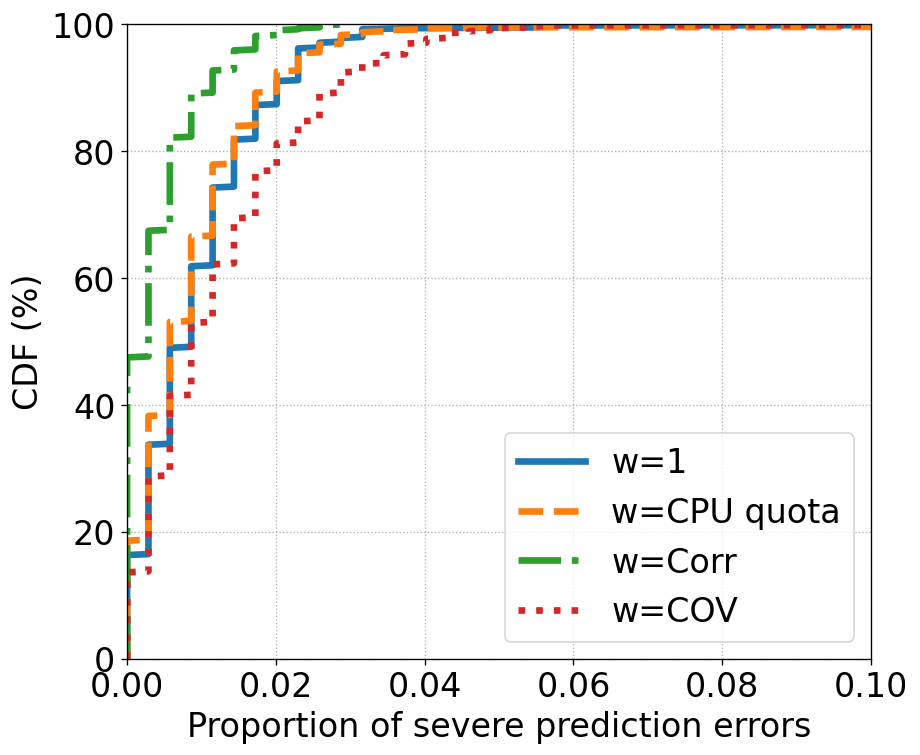

In [216]:
predict = new_P
y = new_T
fontsize=20
plt.figure(figsize=(8, 7), dpi=120)
for i, n, ls in zip(range(y.shape[0]), ["w=1", "w=CPU quota", "w=Corr", "w=COV"], ["-", "--", "-.", ":"]):
    f1 = []
    for j in range(y.shape[1]):
        cnt = [[0, 0], [0, 0]]
        for k in range(predict.shape[2]):
            cnt[int(predict[i, j, k]<3)][int(y[i, j, k]>8)] += 1
        f1.append(cnt[1][1] / predict.shape[2])
    plt.plot(sorted(f1), np.arange(len(f1))*100 / (len(f1) - 1), label=n, lw=4, ls=ls)
plt.xlim(0, 0.1)
plt.xlabel("Proportion of severe prediction errors", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("CDF (%)", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0, 100)
plt.legend(fontsize=fontsize, loc="lower right")
plt.grid(ls=":")
# plt.savefig("./figure/ml-risk.png", bbox_inches="tight")
plt.show()

In [2141]:
temp = [2.4869791666666665,
2.4713541666666665,
2.4713541666666665,
2.4765625,
2.4322916666666665,
2.4270833333333335,
2.4479166666666665,
2.4140625,
2.4635416666666665,
2.4348958333333335,
2.3984375,
2.375,
2.375,
2.3541666666666665,
2.375,
2.3828125,
2.3932291666666665,
2.4140625,
2.4348958333333335,
2.4479166666666665,
2.3958333333333335,
2.4036458333333335,
2.4296875,
2.4036458333333335,
2.4375,
2.4348958333333335,
2.3958333333333335,
2.3854166666666665,
2.3619791666666665,
2.3645833333333335,
2.3984375,
2.3723958333333335,
2.3776041666666665,
2.4166666666666665,
2.4322916666666665,
2.4244791666666665,
2.4166666666666665,
2.4296875,
2.421875,
2.4375,
2.4166666666666665,
2.375,
2.3671875,
2.3645833333333335,
2.34375,
2.3515625,
2.34375,
2.3359375,
2.3463541666666665,
2.3359375,
2.3567708333333335,
2.3645833333333335,
2.375,
2.375,
2.3541666666666665,
2.3619791666666665,
2.4296875,
2.4401041666666665,
2.4296875,
2.4036458333333335]
np.mean(temp)

2.4014756944444446

In [2160]:
df = data[(data.sample_time==1644501780)]
X = df.X.values
nc_sn = df.nc_sn.values
temp = []
for i in range(nc_sn.shape[0]):
    temp.append(MODEL[nc_sn[i]].predict(X[i].reshape(1,-1)))

In [2165]:
np.mean(df.machine_cpu), np.std(df.machine_cpu)

(46.322846667494815, 15.1292234792441)